<a href="https://colab.research.google.com/github/ManuelOtt-code/Project-DC/blob/master/Morgan_ML_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import packages
# Install RDKit
!pip install rdkit

# Library imports
from pathlib import Path
from warnings import filterwarnings
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# RDKit
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

# Scikit-learn
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import (
    auc, accuracy_score, recall_score, roc_curve, roc_auc_score, RocCurveDisplay
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, f_classif, mutual_info_classif, chi2
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
#get data from github (and function file)
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master/func.py
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master//data_extraction%2Bcuration/Landrum_Phenol_training_data.csv
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master//data_extraction%2Bcuration/Landrum_Phenol_test_data.csv
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master//data_extraction%2Bcuration/Landrum_All_test_data.csv
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master//data_extraction%2Bcuration/Landrum_All_training_data.csv
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master//data_extraction%2Bcuration/Minimal_Phenol_training_data.csv
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master//data_extraction%2Bcuration/Minimal_Phenol_test_data.csv
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master//data_extraction%2Bcuration/Minimal_All_test_data.csv
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master//data_extraction%2Bcuration/Minimal_All_training_data.csv

--2025-05-20 16:20:20--  https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master/func.py
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/refs/heads/master/func.py [following]
--2025-05-20 16:20:20--  https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/refs/heads/master/func.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6467 (6.3K) [text/plain]
Saving to: ‘func.py’

func.py             100%[===================>]   6.32K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2025-05-20 16:20:20 (45.0 MB/s) - ‘func.py’ sav

In [ ]:
#convert all CSV files -> dataframe
df_Landrum_Phenol_training_data = pd.read_csv("Landrum_Phenol_training_data.csv")
df_Landrum_Phenol_test_data = pd.read_csv("Landrum_Phenol_test_data.csv")
df_Landrum_All_training_data = pd.read_csv("Landrum_All_training_data.csv")
df_Landrum_All_test_data = pd.read_csv("Landrum_All_test_data.csv")
df_Minimal_Phenol_training_data = pd.read_csv("Minimal_Phenol_training_data.csv")
df_Minimal_Phenol_test_data = pd.read_csv("Minimal_Phenol_test_data.csv")
df_Minimal_All_training_data = pd.read_csv("Minimal_All_training_data.csv")
df_Minimal_All_test_data = pd.read_csv("Minimal_All_test_data.csv")

In [ ]:
#selection on what data files we want to calculate features
datasets = {
    "Landrum_Phenol_training": df_Landrum_Phenol_training_data,
    "Landrum_All_training": df_Landrum_All_training_data,
    "Landrum_Phenol_test": df_Landrum_Phenol_test_data,
    "Landrum_All_test": df_Landrum_All_test_data,
    "Minimal_Phenol_training": df_Minimal_Phenol_training_data,
    "Minimal_All_training": df_Minimal_All_training_data,
    "Minimal_Phenol_test": df_Minimal_Phenol_test_data,
    "Minimal_All_test": df_Minimal_All_test_data
}

COMPUTE = {
    "Landrum_Phenol_training": True,
    "Landrum_All_training": False,
    "Landrum_Phenol_test": True,
    "Landrum_All_test": False,
    "Minimal_Phenol_training": False,
    "Minimal_All_training": False,
    "Minimal_Phenol_test": False,
    "Minimal_All_test": False
}

In [ ]:
# Define a function to convert SMILES to morgan fingerprints
def smiles_to_fingerprints(smiles, n_bits=2048):
    """
    Converts a SMILES string to a molecular fingerprint.

    Parameters
    ----------
    smiles : str
        A SMILES string representing the molecular structure.
    n_bits : int, Optional, default: 1024
        The number of bits in the fingerprint.

    Returns
    -------
    list
        A list of integers representing the molecular fingerprint.
        Returns None if the SMILES string is invalid.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=n_bits)
        return mfpgen.GetFingerprint(mol)
    else:
        return None # Return a zero vector if the SMILES is invalid

def generate_all_morgan_features(df, n_bits=2048):
    df['features'] = df['canonical_Smiles'].apply(
        lambda s: list(smiles_to_fingerprints(s, n_bits)) if smiles_to_fingerprints(s, n_bits) is not None else [0]*n_bits
    )

    features_df = pd.DataFrame(df['features'].tolist(), index=df.index)
    features_df.columns = [f'fp_{i}' for i in range(n_bits)]

    df = pd.concat([df.drop('features', axis=1), features_df], axis=1)
    return df

In [ ]:
#Generate Morgan fingerprints for selected files

morgan_fp = {}

for name, df in datasets.items():
    if COMPUTE.get(name, False):
        print(f"✅ Computing: {name}")
        morgan_fp[name] = generate_all_morgan_features(df)
        morgan_fp[name].to_csv(f"{name}_morgan.csv", index=False)
    else:
        print(f"⏭️ Skipping: {name}")

✅ Computing: Landrum_Phenol_training
⏭️ Skipping: Landrum_All_training
✅ Computing: Landrum_Phenol_test
⏭️ Skipping: Landrum_All_test
⏭️ Skipping: Minimal_Phenol_training
⏭️ Skipping: Minimal_All_training
⏭️ Skipping: Minimal_Phenol_test
⏭️ Skipping: Minimal_All_test


In [ ]:
df2345=pd.read_csv("Landrum_Phenol_training_morgan.csv")
df2345.head()

,canonical_Smiles,active,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,...,fp_2038,fp_2039,fp_2040,fp_2041,fp_2042,fp_2043,fp_2044,fp_2045,fp_2046,fp_2047
0,Cc1cc(/N=C/c2ccc(Br)cc2)c(C(C)C)cc1O,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CCOC(=O)[C@H]1OC(=O)c2cc(O)c(O)c(O)c2[C@@H]1[C...,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,O=C1c2c(O)cc(O)cc2O[C@H](c2cc(O)ccc2O)[C@H]1O,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Cc1c(O)cc(O)cc1[C@H](C)[C@@H](C)O,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,COc1ccc(CC(=O)c2c(O)cc(O)cc2O)cc1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#alternative feature selection

def drop_non_numeric_columns(df):
    """Drops columns from a DataFrame that do not contain numeric values.

    Args:
        df: The input DataFrame.

    Returns:
        A new DataFrame with non-numeric columns removed.
    """
    numeric_df = df.select_dtypes(include=np.number)
    return numeric_df

#------------------------------------------------------------------------------------------

class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold

    def fit(self, X, y=None):
        df = pd.DataFrame(X)
        corr_matrix = df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        self.to_drop_ = set()
        for col1 in upper.columns:
            for col2 in upper.index:
                if col1 == col2:
                    continue
                if upper.loc[col2, col1] > self.threshold:
                    self.to_drop_.add(col2)  # Arbitrary: could also keep based on y

        return self

    def transform(self, X):
        df = pd.DataFrame(X)
        return df.drop(columns=self.to_drop_, errors="ignore").values

In [ ]:
Landrum = True
Phenol = True

if Landrum:
    if Phenol:
        df_training = pd.read_csv("Landrum_Phenol_training_morgan.csv")
        df_test = pd.read_csv("Landrum_Phenol_test_morgan.csv")
    else:
        df_training = pd.read_csv("Landrum_All_training_mordred.csv")
        df_test = pd.read_csv("Landrum_All_test_mordred.csv")
else:
    if Phenol:
        df_training = pd.read_csv("Minimal_Phenol_training_mordred.csv")
        df_test = pd.read_csv("Minimal_Phenol_test_mordred.csv")
    else:
        df_training = pd.read_csv("Minimal_All_training_mordred.csv")
        df_test = pd.read_csv("Minimal_All_test_mordred.csv")

# === Normalize column names just once ===
df_training.columns = df_training.columns.str.strip().str.lower()
df_test.columns = df_test.columns.str.strip().str.lower()

# Configuration switches
USE_MORDRED = False       # True for Mordred, False for Morgan

if USE_MORDRED:
    # Drop non-numeric columns and NaNs
    df_training = drop_non_numeric_columns(df_training)
    df_training = df_training.dropna(axis=1)
    df_test = drop_non_numeric_columns(df_test)
    df_test = df_test.dropna(axis=1)

    # Prepare features and labels
    X_train = df_training.drop(columns=["active", "is_phenol"], errors='ignore')
    y_train = df_training["active"]
    X_test = df_test.drop(columns=["active", "is_phenol"], errors='ignore')
    y_test = df_test["active"]


else:
    #X_train = np.array(df_training["features"].to_list())
    X_train = df_training.drop(columns=['active', 'canonical_smiles']).to_numpy()
    y_train = df_training["active"]
    #X_test = np.array(df_test["features"].to_list())
    X_test = df_test.drop(columns=['active', 'canonical_smiles']).to_numpy()
    y_test = df_test["active"]

In [ ]:
# Define Preprocessing and Models
from sklearn.metrics import classification_report

def get_model_pipeline(model_name):
    if model_name == 'RandomForest':
        model = RandomForestClassifier(class_weight='balanced', random_state=42)
    elif model_name == 'SVM':
        model = SVC(class_weight='balanced', probability=True, random_state=42)
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(class_weight='balanced', solver='saga', random_state=42)
    elif model_name == 'NeuralNetwork':
        model = MLPClassifier(max_iter=1000, random_state=42)
    else:
        raise ValueError(f"Model {model_name} is not supported.")

    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),#'scaler', StandardScaler()
        ("var_thresh", VarianceThreshold(threshold=0.01)),#light filtering of low variance features (more often seen than the 80% constant value method but should do approx the same)
        #("corr_filter", CorrelationFilter(threshold=0.95)), #custom light filtering of highly correlated features (removes feature with lower correlation to activity value)
        ("anova", SelectKBest(score_func=chi2, k=50)),  # Supervised Filter-Based Selection with ANOVA, k can be tuned
        ('classifier', model)
    ])

    return pipeline

In [ ]:
param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'anova__k': [50, 100, 200],
        'classifier__max_features': ['sqrt', 'log2']
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'anova__k': [50, 100, 200],
        'classifier__kernel': ['linear', 'rbf']
    },
    'LogisticRegression': {
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__C': [0.1, 0.01, 0.001],
    'anova__k': [50, 100, 200],
    'classifier__l1_ratio': [0.25, 0.5, 0.75]
    },
    'NeuralNetwork': {
        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'classifier__alpha': [0.0001, 0.001],
        'anova__k': [50, 100, 200],
        'classifier__learning_rate': ['constant', 'adaptive']
    }
}


In [ ]:
#Hyperparameter Tuning with Cross-Validation
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
def perform_grid_search(pipeline, param_grid, X_train, y_train):
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=kf,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    return grid_search

In [ ]:
#Model Evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, f1_score, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.base import clone

#everything called test has nothing to do with test set (is validation but called test in scikit learn)
def evaluate_model_with_cv(model, X, y, random_state):
    """
    Evaluate a model using 10-fold cross-validation and return performance metrics.

    Parameters:
        model: The model to evaluate
        X: Feature matrix
        y: Target vector
        random_state: Random seed for reproducibility

    Returns:
        Dictionary with performance metrics and arrays of per-fold metrics
    """
    t0 = time.time()
    # Initialize KFold
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)


    # Lists to store metrics
    metrics = {
        'accuracies': [],
        'precisions': [],
        'f1_scores': [],
        'auc_scores': [],
        'kappa_scores': []
    }

    # Create figure for ROC curves
    plt.figure()

    # Iterate over folds
    for k, (train_index, test_index) in enumerate(skf.split(X, y)):
        # Split data
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        # Train model
        model.fit(X_train_fold, y_train_fold)

        # Predict
        y_pred_fold = model.predict(X_test_fold)
        y_prob_fold = model.predict_proba(X_test_fold)[:, 1]

        # Calculate metrics
        metrics['accuracies'].append(accuracy_score(y_test_fold, y_pred_fold))
        metrics['precisions'].append(precision_score(y_test_fold, y_pred_fold))
        metrics['f1_scores'].append(f1_score(y_test_fold, y_pred_fold))
        metrics['auc_scores'].append(roc_auc_score(y_test_fold, y_prob_fold))
        metrics['kappa_scores'].append(cohen_kappa_score(y_test_fold, y_pred_fold))

        # ROC curve
        RocCurveDisplay.from_predictions(y_test_fold, y_prob_fold, name=f"Fold {k+1}", ax=plt.gca())


    # Print metrics
    metric_display_names = {
    'accuracies': 'accuracy',
    'precisions':'precision',
    'f1_scores': 'F1 score',
    'auc_scores': 'AUC score',
    'kappa_scores': 'Cohens kappa'
    }

    for metric_name, values in metrics.items():
      display_name = metric_display_names[metric_name]
      print(f"Average {display_name}: {np.mean(values):.4f} \t and std err: {stats.sem(values):.4f}")
    print(f"Time taken : {time.time() - t0:.2f}s\n")
    return metrics


Training and evaluating RandomForest...
Time taken : 126.70s

Hyperparameters: {'anova__k': 200, 'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__n_estimators': 200}

Average accuracy: 0.8515 	 and std err: 0.0109
Average precision: 0.8765 	 and std err: 0.0110
Average F1 score: 0.9102 	 and std err: 0.0063
Average AUC score: 0.8731 	 and std err: 0.0131
Average Cohens kappa: 0.4834 	 and std err: 0.0438
Time taken : 5.80s



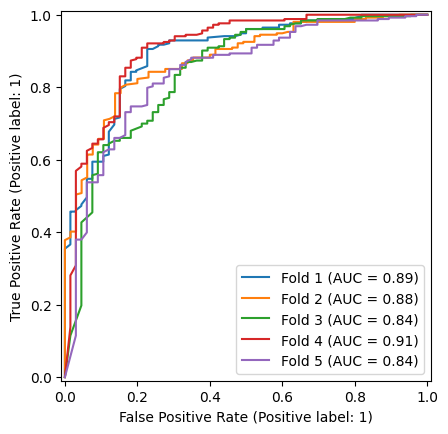

In [ ]:
# loop through each model, perform grid search, and evaluate
import matplotlib.pyplot as plt
from scipy.stats import sem
for model_name in ['RandomForest']: #'NeuralNetwork','RandomForest', 'SVM', 'LogisticRegression',
    print(f"\nTraining and evaluating {model_name}...")
    t0 = time.time()
    pipeline = get_model_pipeline(model_name)
    param_grid = param_grids[model_name]
    grid_search = perform_grid_search(pipeline, param_grid, X_train, y_train)
    model = grid_search.best_estimator_
    print(f"Time taken : {time.time() - t0:.2f}s\n")
    print(f"Hyperparameters: {grid_search.best_params_}\n")
    evaluate_model_with_cv(model, X_train, y_train, random_state=22)